***
# Pile Up Augmentation
***

*Correspondence to: felix.wagner@oeaw.ac.at*

In this notebook we explore the data augmentation module of the Cait Python package again and create pile up events of a detector. This notebook is based on the workshop presentation "Nonlinear pile-up separation with LSTM neural networks for cryogenic particle detectors", at the Machine Learning for the Physical Sciences workshop at Neurips21 (https://ml4physicalsciences.github.io/2021/).

In [1]:
from cait.augment import ParameterSampler, plot_events, unfold, L2, EventDefinition, Distribution
import numpy as np
import cait as ai 
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from tqdm.auto import tqdm
from scipy import signal
from PIL import Image, ImageDraw
import os
%config InlineBackend.figure_formats = ['svg']

In [2]:
if not os.path.exists('test_data/'):
    os.makedirs('test_data/')

Some definitions for the plots.

In [3]:
mpl.rcParams['figure.figsize'] = (7.2, 4.45)
mpl.rcParams['savefig.dpi'] = 300

Define the global parameters.

For the whole notebook: Only capitalized parameters need to be set by the user.

In [4]:
RECORD_LENGTH = 16384
SAMPLE_FREQUENCY = 25000
RESOLUTION = 0.01

POLYNOMIAL_DRIFTS = True
RASTERIZE = False
SQUARE_WAVES = False
SATURATION = True
CLASS_NAMES = [#'Event Pulse',
               #'Noise',
               #'Decaying Baseline',
               #'Temperature Rise',
               #'Spike',
               #'Squid Jump',
               #'Reset',
               #'Cosinus Tail',
               #'Decaying Baseline with Event Pulse',
               'Pile Up',
               #'Early or late Trigger',
               #'Carrier Event',
               #'Decaying Baseline with Tail Event',
               ]


# ----------------------------------------- 
# no need to change below parameters
# ----------------------------------------- 

label_names = {
    'unlabeled': 0,
    'Event Pulse': 1,
    'Test/Control Pulse': 2,
    'Noise': 3,
    'Squid Jump': 4,
    'Spike': 5,
    'Early or late Trigger': 6,
    'Pile Up': 7,
    'Carrier Event': 8,
    'Strongly Saturated Event Pulse': 9,
    'Strongly Saturated Test/Control Pulse': 10,
    'Decaying Baseline': 11,
    'Temperature Rise': 12,
    'Stick Event': 13,
    'Square Waves': 14,
    'Human Disturbance': 15,
    'Large Sawtooth': 16,
    'Cosinus Tail': 17,
    'Light only Event': 18,
    'Ring & Light Event': 19,
    'Sharp Light Event': 20,
    'Reset': 21,
    'Decaying Baseline with Event Pulse': 22,
    'Decaying Baseline with Tail Event': 23,
    'unknown/other': 99,
}

We define the sampler class.

In [5]:
parsam = ParameterSampler(record_length=RECORD_LENGTH,
                          sample_frequency=SAMPLE_FREQUENCY)

We define the detector resolution. The measured resolution will deviate from the set resolution, depending on the noise power spectrum and the method for reconstructing the resolution.

In [6]:
parsam.set_args(resolution=np.array([RESOLUTION]))

For the pile up data set we define a custom event definition.

In [7]:
class PileUpEventDefinition(EventDefinition):

    def get_class_pars(self, label, size, **kwargs):

        if label == 'Event Pulse':
            pileups = np.ones(size)
            ps_nmbr = 0
            decay = False
            rise = False
            spike = False
            jump = False
            pulse_reset = False
            tail = False
            onset_iv = np.array([-160, 400]) * 0.001

        elif label == 'Pile Up':
            pileups = int(2)*np.ones(size, dtype=int) # np.random.choice(a=[2, 3], size=size, p=[0.5, 0.5])
            ps_nmbr = 0
            decay = False
            rise = False
            spike = False
            jump = False
            pulse_reset = False
            tail = False
            onset_iv = np.array([-20, 20]) * 0.001

        else:
            raise KeyError('Class {} not available.'.format(label))

        return pileups, ps_nmbr, decay, rise, spike, jump, pulse_reset, tail, onset_iv


In [8]:
class PileUpPulseHeights(Distribution):

    def __init__(self, mini=0, maxi=0.5):
        self.mini = mini
        self.maxi = maxi

    def sample(self, size, **kwargs):

        pulse_height = np.random.uniform(low=self.mini, high=self.maxi, size=size)

        return pulse_height

In [9]:
parsam.set_args(event_definition=PileUpEventDefinition())

In [10]:
parsam.set_args(ph_dist=PileUpPulseHeights())

We define the pulse shapes. You can always resample, in case you don't like them.

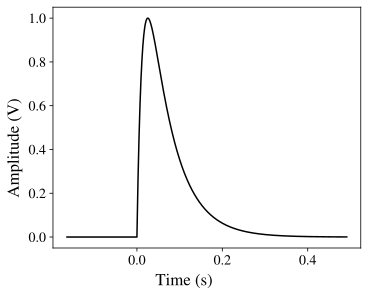

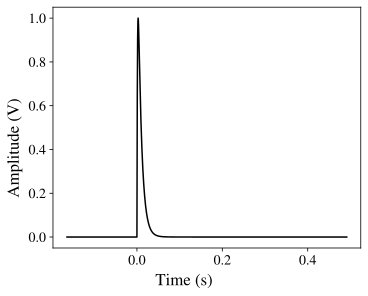

In [12]:
# sample pulse shapes

# ps1, _ = parsam.sample_pulse_par(size=1, t0=np.array([0.]))
# ps2, _ = parsam.sample_pulse_par(size=1, t0=np.array([0.]))
# print(ps1)
# print(ps2)

mpl.rcParams['figure.figsize'] = (5, 4)
# mpl.rcParams['savefig.dpi'] = 300
fontsize = 14

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# or define your own pulse shapes ...
ps1 = {'t0': np.array([0.]), 
       'tau_t': np.array([0.05815608]), 
       'tau_in': np.array([0.02059209]), 
       'tau_n': np.array([0.01395427]), 
       'An': np.array([-0.02508469])/0.0715207609981429, 
       'At': np.array([0.14102789])/0.0715207609981429}
ps2 = {'t0': np.array([0.]), 
       'tau_t': np.array([0.01730027]), 
       'tau_in': np.array([0.00128385]), 
       'tau_n': np.array([0.00815371]), 
       'An': np.array([2.59789859])/1.553262177826752,
       'At': np.array([0.02694577])/1.553262177826752}

for i,p in enumerate([ps1, ps2]):

    event = ai.fit.pulse_template(parsam.t, **unfold(p, 1))
    plot_events(event.reshape(1,-1), t=parsam.t, show=True, 
                savepath='test_data/pulse_shape_{}.pdf'.format(i), text=[''])  # 'Standard Event'
    
parsam.set_args(pulse_shapes=[[ps1['t0'], ps1['An'], ps1['At'], ps1['tau_n'], ps1['tau_in'], ps1['tau_t']],
                              [ps2['t0'], ps2['An'], ps2['At'], ps2['tau_n'], ps2['tau_in'], ps2['tau_t']],
                              ])

We define the noise power spectrum. You can always resample, in case you don't like it.

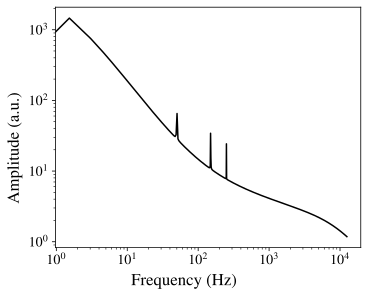

In [14]:
# sample nps

parsam.set_args(nps=None)

noise_par, info = parsam.sample_noise(size=1)

# or define your own nps ...
# noise_par['nps'] = nps[:, 1].reshape(1,-1)
# info['fq'] = np.fft.rfftfreq(n=RECORD_LENGTH, d=1 / SAMPLE_FREQUENCY)

# plot begin -------

plt.close()

fig, ax = plt.subplots(constrained_layout=True)

ax.loglog(info['fq'], noise_par['nps'][0], color='black', linewidth=1.5, zorder=50)

# eye guidelines

fig.supxlabel('Frequency (Hz)')
fig.supylabel('Amplitude (a.u.)')
ax.text(x=.6,y=.5,s='',  # 'Noise Power Spectrum', 
        transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='white', alpha=0.8, ec='k'))
plt.savefig('test_data/noise_power_spectrum.pdf')
plt.show()

parsam.set_args(nps=noise_par['nps'])

We define the saturation curve. You can always resample, in case you don't like it.

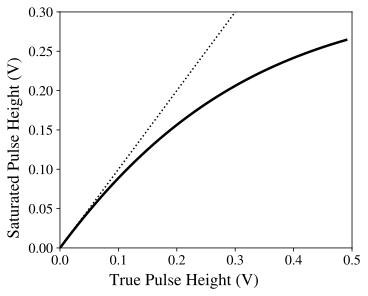

In [15]:
# sat = parsam.sample_saturation(size=1)
# print(sat)

# or define your own saturation ...
#sat = {'K': np.array([8.8786987]),
#       'C': np.array([1.23606841]),
#       'Q': np.array([2.12402435]),
#       'B': np.array([0.57876924]),
#       'nu': np.array([1.61744008]),
#       'A': np.array([-7.95906284])}

sat = {'K': np.array([10]),
       'C': np.array([3]),
       'Q': np.array([0.5]),
       'B': np.array([5]),
       'nu': np.array([0.5])}

sat['A'] = sat['K'] / (1 - (sat['C'] + sat['Q'])**(1/sat['nu']))

plt.close()

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(np.arange(0, 0.5, 0.01), ai.fit.scaled_logistic_curve(np.arange(0, 0.5, 0.01), **sat), color='black', linewidth=2.5)
ax.plot(np.arange(0, 0.5, 0.01), np.arange(0, 0.5, 0.01), linestyle='dotted', color='black')

fig.supxlabel('True Pulse Height (V)')
fig.supylabel('Saturated Pulse Height (V)')

ax.set_xlim(0,0.5)
ax.set_ylim(0,0.3)

ax.text(x=.6,y=.3,s='', transform=ax.transAxes,  # Saturation Curve
        bbox=dict(boxstyle='square', fc='white', alpha=0.8, ec='k'))

plt.savefig('test_data/saturation_curve.pdf')
plt.show()

parsam.set_args(saturation_pars=sat)

Plot some augmented events.

Sample Noise...



Sample Polynomials...



Sample Pulse Nmbr  0
Sample Pulse Nmbr  1
Sample Saturation ...
Pile Up


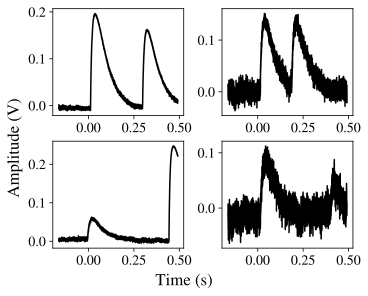

In [16]:
NMBR_PLOTS = 1

# classes = np.random.choice(CLASS_NAMES, size=NMBR_PLOTS)
classes = [CLASS_NAMES[0] for i in range(NMBR_PLOTS)]

for i in range(NMBR_PLOTS):

    event, info = parsam.get_event(label=classes[i],
                                   size=4,
                                   rasterize=RASTERIZE,
                                   poly=POLYNOMIAL_DRIFTS,
                                   square=SQUARE_WAVES,
                                   saturation=SATURATION,
                                   verb=True,
                                   )

    print(classes[i])
    plot_events(event, t=parsam.t, show=False)
    if classes[i] == 'Event Pulse':
        print('Resolution (only meaningful without Saturation): ', np.std(np.abs(np.max(event, axis=1) - info['pulse_height'])))

Create an HDF5 data set.

In [18]:
FNAME = 'test_data/pileup_v0_6.h5'
IDX = list(range(1))  # which to take from the class names
BATCHSIZE = 500
EVENTS_PER_CLASS = {
    #'Event Pulse': 30000,  # 9000,
    #'Noise': 9000,
    #'Decaying Baseline': 1500,
    #'Temperature Rise': 1500,
    #'Spike': 1500,
    #'Squid Jump': 1500,
    #'Reset': 6000,
    #'Cosinus Tail': 3000,
    #'Decaying Baseline with Event Pulse': 3000,
    #'Decaying Baseline with Tail Event': 3000,
    'Pile Up': 3000,  # 9000,
    #'Early or late Trigger': 3000,
    #'Carrier Event': 9000,
}
DIV = 1
TOTAL_EVENTS = int(np.sum(list(EVENTS_PER_CLASS.values()))/DIV)
BATCHSIZE = int(BATCHSIZE/DIV)

NMBR_PILEUP = 2

# -------------------------------------------
# no changes required below this line!
# -------------------------------------------

with h5py.File(FNAME, 'w') as f:
    
    f.require_group('events')
    f['events'].create_dataset('event',
                                shape=(1, TOTAL_EVENTS, RECORD_LENGTH),
                                dtype=np.float32)
    f['events'].create_dataset('labels',
                                shape=(1, TOTAL_EVENTS),
                                dtype=int)
    f['events'].create_dataset('true_ph',
                                shape=(1, TOTAL_EVENTS),
                                dtype=float)
    f['events'].create_dataset('true_onset',
                                shape=(TOTAL_EVENTS, ),
                                dtype=float)
    
    f['events'].create_dataset('pulse_traces',
                            shape=(1, TOTAL_EVENTS, NMBR_PILEUP, RECORD_LENGTH),
                            dtype=np.float32)
    f['events'].create_dataset('pulse_height_pileup',
                        shape=(1, TOTAL_EVENTS, NMBR_PILEUP),
                        dtype=np.float32)
    f['events'].create_dataset('t0_pileup',
                    shape=(1, TOTAL_EVENTS, NMBR_PILEUP),
                    dtype=np.float32)

    f.require_group('saturation')
    f['saturation'].create_dataset('fitpar',
                                    data=np.array([sat['A'], sat['K'], sat['C'], sat['Q'], sat['B'], sat['nu'], ]))

    bar = tqdm(total=TOTAL_EVENTS)
    bcount = 0

    for i in IDX:

        bar.write('Simulating {} ...'.format(CLASS_NAMES[i]))

        nmbr_events = int(EVENTS_PER_CLASS[CLASS_NAMES[i]] / DIV)
        batches = int(nmbr_events / BATCHSIZE)

        for b in range(batches):
            event, info = parsam.get_event(label=CLASS_NAMES[i],
                                           size=BATCHSIZE,
                                           rasterize=RASTERIZE,
                                           poly=POLYNOMIAL_DRIFTS,
                                           square=SQUARE_WAVES,
                                           saturation=SATURATION,
                                           verb=False,
                                           )

            f['events']['event'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), :] = event
            f['events']['labels'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = label_names[CLASS_NAMES[i]]
            f['events']['true_ph'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['pulse_height']
            f['events']['true_onset'][int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['t0']*1000
            if 'pulse_traces' in info:
                for j in range(NMBR_PILEUP):
                    f['events']['pulse_traces'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['pulse_traces']
                    f['events']['pulse_height_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), j] = info['pulse_height_pileup_{}'.format(j)]
                    f['events']['t0_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), j] = info['t0_pileup_{}'.format(j)]
            else:
                f['events']['pulse_traces'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = 0
                f['events']['pulse_height_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = 0
                f['events']['t0_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = 0
                f['events']['pulse_traces'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), 0] = event
                f['events']['pulse_height_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), 0] = info['pulse_height']
                f['events']['t0_pileup'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), 0] = info['t0']*1000
                    
            # attributes

            f['events']['labels'].attrs.create(name='unlabeled', data=0)
            f['events']['labels'].attrs.create(name='Event_Pulse', data=1)
            f['events']['labels'].attrs.create(name='Test/Control_Pulse', data=2)
            f['events']['labels'].attrs.create(name='Noise', data=3)
            f['events']['labels'].attrs.create(name='Squid_Jump', data=4)
            f['events']['labels'].attrs.create(name='Spike', data=5)
            f['events']['labels'].attrs.create(name='Early_or_late_Trigger', data=6)
            f['events']['labels'].attrs.create(name='Pile_Up', data=7)
            f['events']['labels'].attrs.create(name='Carrier_Event', data=8)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Event_Pulse', data=9)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Test/Control_Pulse', data=10)
            f['events']['labels'].attrs.create(name='Decaying_Baseline', data=11)
            f['events']['labels'].attrs.create(name='Temperature_Rise', data=12)
            f['events']['labels'].attrs.create(name='Stick_Event', data=13)
            f['events']['labels'].attrs.create(name='Square_Waves', data=14)
            f['events']['labels'].attrs.create(name='Human_Disturbance', data=15)
            f['events']['labels'].attrs.create(name='Large_Sawtooth', data=16)
            f['events']['labels'].attrs.create(name='Cosinus_Tail', data=17)
            f['events']['labels'].attrs.create(name='Light_only_Event', data=18)
            f['events']['labels'].attrs.create(name='Ring_Light_Event', data=19)
            f['events']['labels'].attrs.create(name='Sharp_Light_Event', data=20)
            f['events']['labels'].attrs.create(name='Reset', data=21)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Event_Pulse', data=22)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Tail_Pulse', data=23)
            f['events']['labels'].attrs.create(name='unknown/other', data=99)

            # f['saturation']['fitpar'].attrs.create(name='A', data=0)
            # f['saturation']['fitpar'].attrs.create(name='K', data=1)
            # f['saturation']['fitpar'].attrs.create(name='C', data=2)
            # f['saturation']['fitpar'].attrs.create(name='Q', data=3)
            # f['saturation']['fitpar'].attrs.create(name='B', data=4)
            # f['saturation']['fitpar'].attrs.create(name='nu', data=5)

            bar.update(BATCHSIZE)
            bcount += 1


Simulating Pile Up ...


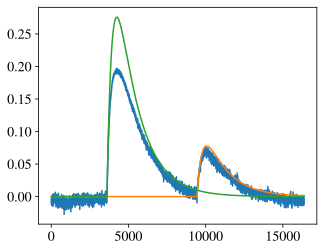

In [19]:
with h5py.File(FNAME, 'r+') as f:
    idx = 5
    plt.plot(f['events']['event'][0, idx])
    for i in range(NMBR_PILEUP):
        plt.plot(f['events']['pulse_traces'][0, idx, i])

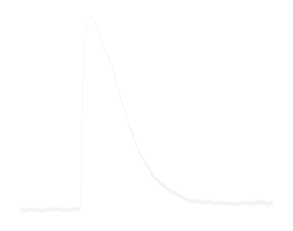

In [20]:
with h5py.File('test_data/pileup_v0_6.h5', 'r+') as f:
    idx = 8
    plt.plot(f['events']['event'][0, idx], color='black', alpha=0.05, linewidth=0.5)
    plt.axis('off')
    plt.savefig('post_background.pdf')
    plt.show()

Done.

## Train the separation model

We simulate the non-pileuped pulses and try to reconstruct the individual ones. We use an LSTM model.

In [5]:
import numpy as np
from cait.cuts import LogicalCut
from cait.fit import scaled_logistic_curve, pulse_template
from cait.models import SeparationLSTM
import os
from pytorch_lightning import Trainer
from torchvision import transforms
import h5py
from cait.datasets import RemoveOffset, Normalize, ToTensor, CryoDataModule, PileUpDownSample
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tqdm.auto import trange, tqdm
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [6]:
fontsize = 14

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [7]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

False


In [8]:
# some parameters
# nmbr_gpus = ... uncommment and put in trainer to use GPUs
path_h5 = 'test_data/pileup_v0_6.h5'
type = 'events'  # the group key for the data in the HDF5 set
keys = ['event', 'pulse_traces']  # the datasets in the group from which we include data in the samples for the NN
channel_indices = [[0], [0]]  # the first indices of the datasets
feature_indices = [None, None]  # the third indices of the datasets
feature_keys = ['event_ch0']    # the keys in the samples of the NN dataset that are input to the NN
                                # in the data set for the NN, the keys have additionally appended the channel index 
label_keys = ['pulse_traces_ch0']  # the keys in the samples of the NN dataset that are labels to the NN
norm_vals = {'event_ch0': [0, 0.5], 'pulse_traces_ch0': [0, 0.5]}  # we do a min - max normalization of all samples, so these are roughly the lowest and highest values of the events in the data set
down_keys = ['event_ch0', 'pulse_traces_ch0']  # if we input the raw time series, we apply downsampling first
down = 64                  # all samples in the NN dataset with the indices specified above are by the factor down downsampled
record_length = 16384
max_epochs = 5  # the maximal trianing epochs of the neural network

save_naming = 'lstm'  # 'lstm' or 'unet'
nmbr_pileup = 2
plots = True

## Dataset and Model

In [9]:
# create the transforms
trans = transforms.Compose([# RemoveOffset(keys=feature_keys),
                            Normalize(norm_vals=norm_vals),
                            PileUpDownSample(keys=down_keys, down=down),
                            ToTensor()])

In [10]:
# create data module and init the setup
dm = CryoDataModule(hdf5_path=path_h5,
                    type=type,
                    keys=keys,
                    channel_indices=channel_indices,
                    feature_indices=feature_indices,
                    transform=trans)

In [11]:
dm.prepare_data(val_size=0.1,
                test_size=0.2,
                batch_size=64,
                dataset_size=None,
                nmbr_workers=0,  # set to number of CPUS on the machine (strange fact: for me 0 is faster than 8?) probabily inefficient implementation of our dataset for multithreading (issue on GitLab is open)
                only_idx=None,
                shuffle_dataset=True,
                random_seed=21,  # 21, 1, 2, 3, 4
                feature_keys=feature_keys,
                label_keys=label_keys,
                keys_one_hot=label_keys)

In [12]:
dm.setup()

In [37]:
if save_naming == 'lstm':
    
    ips = 16
    
    model = SeparationLSTM(
        input_size=ips,
        hidden_size=ips * 10,
        num_layers=3,
        seq_steps=int(dm.dims[1] / ips),  # downsampling is already considered in dm
        nmbr_pileup=nmbr_pileup, 
        device_name=device,
        lr=1e-3,
        feature_keys=feature_keys,
        label_keys=label_keys,
        down=down,
        down_keys=feature_keys,
        norm_vals=norm_vals,
        offset_keys=feature_keys,
    )

else:
    raise NotImplementedError

## View Events

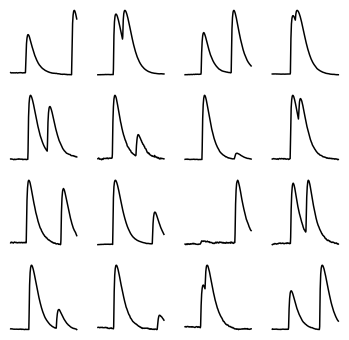

In [38]:
if plots:

    mpl.rcParams['figure.figsize'] = (6, 6)

    width=4
    fig, axes = plt.subplots(nrows=width, ncols=width)
    for i in range(width**2):
        if i < 8:
            idx = i
        else:
            idx = i + 100
        example = dm.dataset_full[idx]['event_ch0']
        axes[int(i/width),int(i%width)].plot(example, color='black')
        axes[int(i/width),int(i%width)].axis('off')
        # axes[int(i/width),int(i%width)].set_ylim((-0.1,1.1))

## Training

In [39]:
checkpoint_callback = ModelCheckpoint(dirpath='callbacks',
                                      monitor='val_loss',
                                      filename=save_naming + '-{epoch:02d}-{val_loss:.2f}')

In [40]:
trainer = Trainer(max_epochs=max_epochs,
                  callbacks=[checkpoint_callback],
                  gpus=0)
# keyword gpus=nmbr_gpus for GPU Usage
# keyword max_epochs for number of maximal epochs

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [41]:
trainer.fit(model=model,
            datamodule=dm)


  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 526 K 
1 | fc   | Linear | 5 K   
/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning:

Please also save or load the state of the optimizer when saving or loading the scheduler.



1

## Evaluation

In [42]:
print('Best model: ', checkpoint_callback.best_model_path)

Best model:  /Users/felix/PycharmProjects/cait/docs/source/tutorials/callbacks/lstm-epoch=03-val_loss=0.00.ckpt


In [43]:
model.load_from_checkpoint(checkpoint_callback.best_model_path)

SeparationLSTM(
  (lstm): LSTM(16, 160, num_layers=3, batch_first=True)
  (fc): Linear(in_features=160, out_features=32, bias=True)
)

In [44]:
# model.cuda()

In [45]:
result = trainer.test(model=model,
            datamodule=dm)
print(result)

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0028),
 'train_loss': tensor(0.0022),
 'val_loss': tensor(0.0029)}
--------------------------------------------------------------------------------

[{'train_loss': 0.0021677217446267605, 'val_loss': 0.002877358580008149, 'test_loss': 0.002773477230221033}]


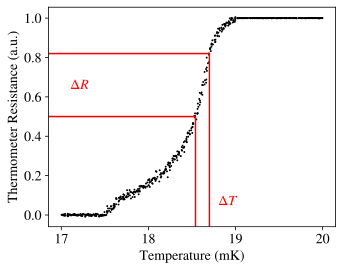

In [46]:
# plot saturation curve

mpl.rcParams['figure.figsize'] = (5, 4)

x_temp = np.arange(17,20,0.005)
y_temp = np.zeros(len(x_temp))
y_temp[x_temp > 17.5] = 1.6*(x_temp[x_temp > 17.5] - 17.5)
y_temp[x_temp > 17.7] = - 1/(x_temp[x_temp > 17.7] - 19) - 0.47
y_temp[x_temp > 18.7] = 0.3*np.log(10*x_temp[x_temp > 18.7] - 10*18.65) + 3
y_temp[x_temp > 19] = 3.38
y_temp[x_temp < 17.5] += np.random.normal(scale=0.01, size=len(x_temp[x_temp < 17.5]))
y_temp[np.logical_and(x_temp < 19, x_temp > 17.5)] += np.random.normal(scale=0.04, size=len(x_temp[np.logical_and(x_temp < 19, x_temp > 17.5)]))
y_temp[x_temp > 19] += np.random.normal(scale=0.0015, size=len(x_temp[x_temp > 19]))
x_temp += np.random.normal(scale=0.01, size=len(x_temp))
y_temp /= y_temp[-1]
y_temp[y_temp > 1.005] = 1.005
y_temp[y_temp < -0.01] = -0.01

plt.axhline(y=0.5, xmax=0.51, color='red')
plt.axhline(y=0.82, xmax=0.56, color='red')
plt.axvline(x=18.54, ymax=0.497, color='red')
plt.axvline(x=18.7, ymax=0.787, color='red')
plt.scatter(x_temp, y_temp, marker='.', s=4, color='black')

plt.text(x=17.1, y=0.64, s='$\Delta R$', color='red')
plt.text(x=18.8, y=0.05, s='$\Delta T$', color='red')

plt.xlabel('Temperature (mK)')
plt.ylabel('Thermometer Resistance (a.u.)')
plt.tight_layout()

plt.savefig('test_data/curve.pdf')
plt.show()

In [47]:
# plot some outputs
f = h5py.File(dm.hdf5_path, 'r')
test_idx = dm.test_sampler.indices[5:10]
test_idx.sort()
x_ = {feature_keys[0]: f[type][keys[0]][channel_indices[0][0], test_idx]}
y_ = np.array(f[type][keys[1]][channel_indices[1][0], test_idx])
seperated = model.predict(x_.copy()).cpu().numpy()

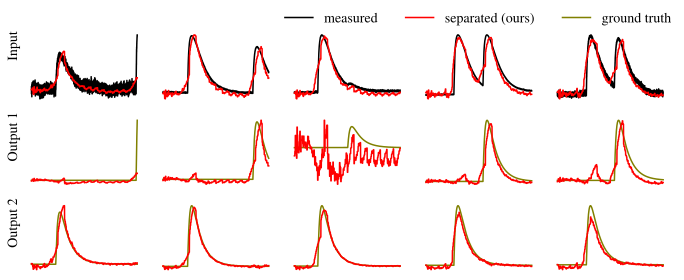

In [48]:
if plots:
    
    sat = {'K': np.array([10]),
       'C': np.array([3]),
       'Q': np.array([0.5]),
       'B': np.array([5]),
       'nu': np.array([0.5])}

    sat['A'] = sat['K'] / (1 - (sat['C'] + sat['Q'])**(1/sat['nu']))

    mpl.rcParams['figure.figsize'] = (10, 4)

    fig, axes = plt.subplots(nrows=nmbr_pileup + 1, ncols=5, sharey=False)

    axes[0, 0].set_title(' ')

    for i in range(5): # rows
        example = x_['event_ch0'][i]
        lab = 'measured' if i == 0 else ''
        axes[0,i].plot(example, color='black', label=lab)
        lab = 'separated (ours)' if i == 0 else ''
        axes[0,i].plot(scaled_logistic_curve(np.sum(seperated[i], axis=0), **sat), color='red', label=lab)
        axes[0,i].axis('off')
        for j in range(nmbr_pileup): # columns
            lab = 'ground truth' if j == 0 and i == 0 else ''
            axes[j+1, i].plot(y_[i, j], color='olive', label=lab)
            sep_ = seperated[i, j]
            axes[j+1, i].plot(sep_, color='red')
            axes[j+1, i].axis('off')
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    fig.legend(lines, labels, ncol=3, frameon=False, loc='upper right', fontsize=14)
    
    axes[0, 0].text(0.06,0.8,'Input',rotation=90, transform=plt.gcf().transFigure)
    axes[1, 0].text(0.06,0.45,'Output 1',rotation=90, transform=plt.gcf().transFigure)
    axes[2, 0].text(0.06,0.15,'Output 2',rotation=90, transform=plt.gcf().transFigure)

    # fig.supylabel('Amplitude (a.u.)')
    # fig.supxlabel('Time (a.u.)')
    fig.tight_layout()
    
    plt.savefig('test_data/events.pdf', dpi=150)
    plt.show()

In [49]:
def get_ph(x):
    return np.max(x - np.mean(x[..., :500], keepdims=True), axis=-1)

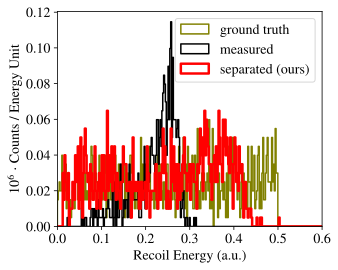

In [52]:
if plots:

    mpl.rcParams['figure.figsize'] = (5, 4)

    bins = np.linspace(0,0.6,300)
    wei = 1/(bins[1] - bins[0])/100000

    plt.hist(ph_true, weights=wei*np.ones(len(ph_true)), bins=bins, 
             label='ground truth', histtype='step', linewidth=1.5, color='olive')
    plt.hist(ph_recon, weights=wei*np.ones(len(ph_recon)), bins=bins, 
             label='measured', histtype='step', linewidth=1.5, color='black')
    plt.hist(ph_sep, weights=wei*np.ones(len(ph_sep)), bins=bins, 
             label='separated (ours)', histtype='step', linewidth=2.5, color='red')

    plt.xlim(0,0.6)
    # plt.ylim(0,2)

    plt.xlabel('Recoil Energy (a.u.)')
    plt.ylabel(r'$10^6$ $\cdot$ Counts / Energy Unit')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('test_data/hist.pdf')
    plt.show()

Done.